© Alexander Jüstel, Fraunhofer IEG, Institution for Energy Infrastructures and Geothermal Systems, RWTH Aachen University,
GNU Lesser General Public License v3.0

# 06 Processing Data Type 3 - Points representative for Administrative Units

This notebook illustrates how to process data of Data Type 3 - Points representative for Administrative Units. The input data is provided as point data corresponding to the heat demand of an entire adminstrative unit. The heat demand will now be distributed according to existing heat demand distributions or according to population density.

## Importing Libraries

In [1]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np

from pyheatdemand import processing 

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Loading Sample Data

The sample data is loaded using `GeoPandas`.

In [2]:
data = gpd.read_file('../../../test/data/Data_Type_III_Point_Administrative_Areas.shp')[['qbedarfges', 'geometry']].drop_duplicates().reset_index(drop=True)
data = data.explode()
data

C:\Users\ale93371\AppData\Local\Temp\ipykernel_11532\2584378194.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  data = data.explode()


,,qbedarfges,geometry
0,0,52210990.0,POINT (4092219.907 2535060.898)
1,0,27559638.0,POINT (4093842.818 2533345.523)
2,0,24212019.0,POINT (4097316.659 2532008.117)
3,0,30285495.0,POINT (4096185.534 2533657.196)


Text(-0.9027777777777768, 0.5, 'Y [m]')

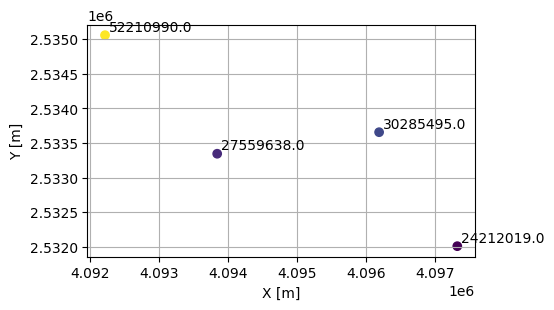

In [3]:
fig, ax = plt.subplots(figsize=(5,5))

data.plot(column='qbedarfges', ax=ax)

for x, y, label in zip(data.geometry.x, data.geometry.y, data['qbedarfges']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Loading Administrative Boundaries

We are loading the administrative boundaries corresponding to each point. 

In [4]:
boundaries = gpd.read_file('../../../test/data/Data_Type_III_Point_Administrative_Areas_Communities.shp')[['geometry']]
boundaries

,geometry
0,"POLYGON ((4092289.339 2533762.537, 4092282.905..."
1,"POLYGON ((4094443.522 2530507.573, 4094442.568..."
2,"POLYGON ((4095957.929 2531508.821, 4095950.755..."
3,"POLYGON ((4095268.268 2532194.964, 4095262.290..."


Text(70.22222222222221, 0.5, 'Y [m]')

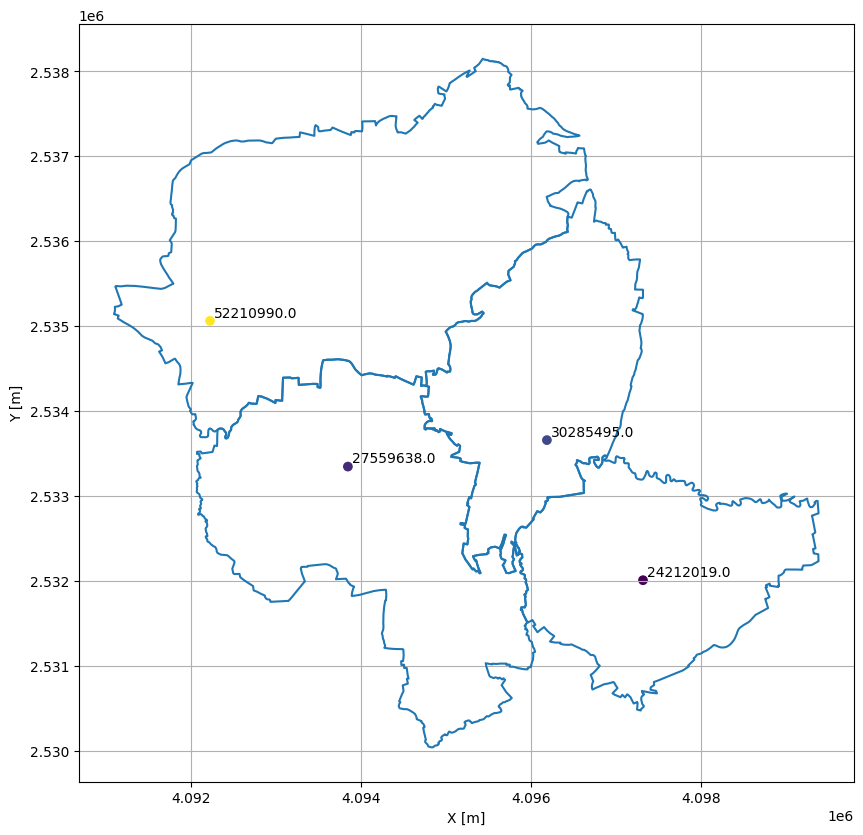

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

boundaries.boundary.plot(ax=ax)
data.plot(ax=ax, column='qbedarfges')

for x, y, label in zip(data.geometry.x, data.geometry.y, data['qbedarfges']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Loading Hotmaps Heat Demand Distribution

Distributing the heat demand across the entire adminstrative area equally would result in an overestimation of heat demand in rural areas and an underestimation of heat demand in highly populated areas. In order to mitigate this fact, we are using the heat demand distribution from hotmaps to populate the total heat heat demand across the areas where actual heat demand is present. The total heat demand is also distributed according to the fraction of each cell compared to the total heat demand of the adminstrative area. 

In [6]:
hd_hotmaps = gpd.read_file('../../../test/data/Data_Type_III_Point_Administrative_Areas_Hotmaps.shp').drop('FID', axis=1)
hd_hotmaps['HeatDemand'] = hd_hotmaps['HD_factori']*1000*hd_hotmaps.area/10000
hd_hotmaps['area'] = hd_hotmaps.area
hd_hotmaps

,HD_factori,geometry,HeatDemand,area
0,0.000659,"POLYGON ((4091484.540 2534851.090, 4091480.599...",0.445521,6755.763078
1,0.000388,"POLYGON ((4091384.540 2535046.940, 4091484.540...",0.387671,10000.000000
2,0.000808,"POLYGON ((4091494.614 2534846.940, 4091484.540...",0.806375,9979.095516
3,0.000761,"POLYGON ((4091484.540 2535046.940, 4091584.540...",0.761312,10000.000000
4,0.455978,"POLYGON ((4091784.540 2534604.981, 4091782.790...",307.432628,6742.271536
...,...,...,...,...
1943,0.698337,"POLYGON ((4096784.540 2533746.940, 4096884.540...",698.337334,10000.000000
1944,1.395606,"POLYGON ((4096784.540 2533846.940, 4096884.540...",1395.605543,10000.000000
1945,4.073406,"POLYGON ((4096784.540 2533946.940, 4096884.540...",4073.405650,10000.000000
1946,13.262840,"POLYGON ((4096784.540 2534046.940, 4096884.540...",13262.839540,10000.000000


Text(70.22222222222221, 0.5, 'Y [m]')

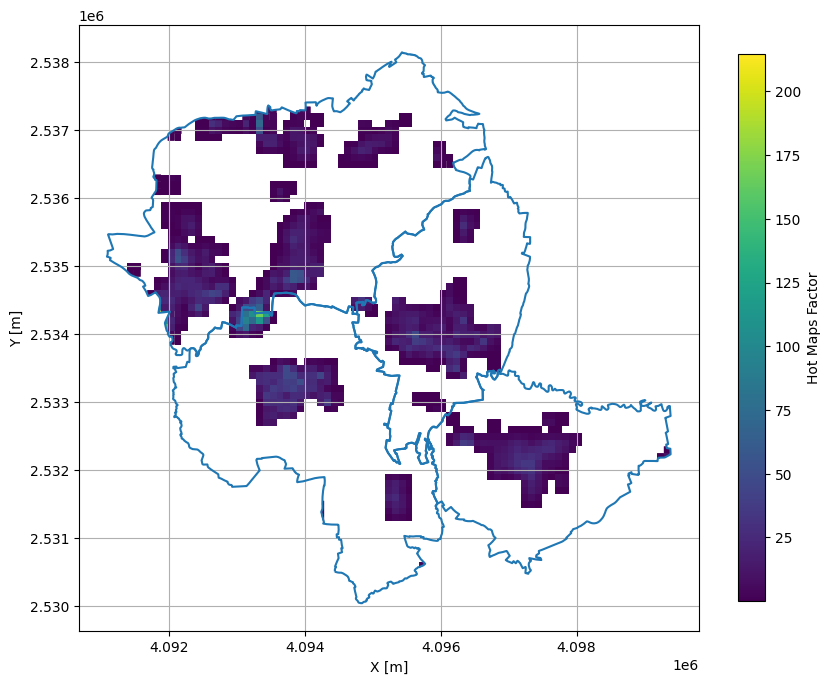

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

boundaries.boundary.plot(ax=ax)
data.plot(ax=ax, column='qbedarfges')
hd_hotmaps.plot(ax=ax,column='HD_factori', legend=True, legend_kwds={'shrink':0.71, 'label': 'Hot Maps Factor'})

plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

In [8]:
hd_hotmaps

,HD_factori,geometry,HeatDemand,area
0,0.000659,"POLYGON ((4091484.540 2534851.090, 4091480.599...",0.445521,6755.763078
1,0.000388,"POLYGON ((4091384.540 2535046.940, 4091484.540...",0.387671,10000.000000
2,0.000808,"POLYGON ((4091494.614 2534846.940, 4091484.540...",0.806375,9979.095516
3,0.000761,"POLYGON ((4091484.540 2535046.940, 4091584.540...",0.761312,10000.000000
4,0.455978,"POLYGON ((4091784.540 2534604.981, 4091782.790...",307.432628,6742.271536
...,...,...,...,...
1943,0.698337,"POLYGON ((4096784.540 2533746.940, 4096884.540...",698.337334,10000.000000
1944,1.395606,"POLYGON ((4096784.540 2533846.940, 4096884.540...",1395.605543,10000.000000
1945,4.073406,"POLYGON ((4096784.540 2533946.940, 4096884.540...",4073.405650,10000.000000
1946,13.262840,"POLYGON ((4096784.540 2534046.940, 4096884.540...",13262.839540,10000.000000


## Spatially join Polygons with Community Heat Demand

The communities are spatially joined with the heat demand data.

In [9]:
boundaries = gpd.sjoin(left_df=boundaries,
                             right_df=data,
                             how='left')#.drop('index_right', axis=1)
boundaries

,geometry,index_right0,index_right1,qbedarfges
0,"POLYGON ((4092289.339 2533762.537, 4092282.905...",0,0,52210990.0
1,"POLYGON ((4094443.522 2530507.573, 4094442.568...",1,0,27559638.0
2,"POLYGON ((4095957.929 2531508.821, 4095950.755...",2,0,24212019.0
3,"POLYGON ((4095268.268 2532194.964, 4095262.290...",3,0,30285495.0


## Overlaying the Heat Demand Data with the Communities

The heat demand data is overlain with the communities. 

In [10]:
hd_hotmaps_overlay = gpd.overlay(hd_hotmaps, boundaries)
hd_hotmaps_overlay.head()

,HD_factori,HeatDemand,area,index_right0,index_right1,qbedarfges,geometry
0,0.000659,0.445521,6755.763078,0,0,52210990.0,"POLYGON ((4091480.599 2534852.714, 4091452.682..."
1,0.000388,0.387671,10000.000000,0,0,52210990.0,"POLYGON ((4091484.540 2535046.940, 4091484.540..."
2,0.000808,0.806375,9979.095516,0,0,52210990.0,"POLYGON ((4091484.540 2534851.090, 4091484.540..."
3,0.000761,0.761312,10000.000000,0,0,52210990.0,"POLYGON ((4091584.540 2535046.940, 4091584.540..."
4,0.455978,307.432628,6742.271536,0,0,52210990.0,"POLYGON ((4091782.790 2534604.113, 4091734.811..."


## Calculate Heat Demand for overlain Polygons

The heat demand for overlain polygons is calculated. 

In [11]:
hd_hotmaps_overlay['area_new'] = hd_hotmaps_overlay.area
hd_hotmaps_overlay['HD'] = hd_hotmaps_overlay['HeatDemand'] * hd_hotmaps_overlay['area_new'] / hd_hotmaps_overlay['area']
hd_hotmaps_overlay.head()

,HD_factori,HeatDemand,area,index_right0,index_right1,qbedarfges,geometry,area_new,HD
0,0.000659,0.445521,6755.763078,0,0,52210990.0,"POLYGON ((4091480.599 2534852.714, 4091452.682...",6755.763078,0.445521
1,0.000388,0.387671,10000.000000,0,0,52210990.0,"POLYGON ((4091484.540 2535046.940, 4091484.540...",10000.000000,0.387671
2,0.000808,0.806375,9979.095516,0,0,52210990.0,"POLYGON ((4091484.540 2534851.090, 4091484.540...",9979.095516,0.806375
3,0.000761,0.761312,10000.000000,0,0,52210990.0,"POLYGON ((4091584.540 2535046.940, 4091584.540...",10000.000000,0.761312
4,0.455978,307.432628,6742.271536,0,0,52210990.0,"POLYGON ((4091782.790 2534604.113, 4091734.811...",6742.271536,307.432628


## Join Heat Demand Data with Communities

The heat demand data will be joined with the communities.

In [12]:
leftjoin_gdf = gpd.sjoin(left_df=hd_hotmaps_overlay,
                             right_df=boundaries,
                             how='left')
leftjoin_gdf.head()

,HD_factori,HeatDemand,area,index_right0_left,index_right1_left,qbedarfges_left,geometry,area_new,HD,index_right,index_right0_right,index_right1_right,qbedarfges_right
0,0.000659,0.445521,6755.763078,0,0,52210990.0,"POLYGON ((4091480.599 2534852.714, 4091452.682...",6755.763078,0.445521,0,0,0,52210990.0
1,0.000388,0.387671,10000.000000,0,0,52210990.0,"POLYGON ((4091484.540 2535046.940, 4091484.540...",10000.000000,0.387671,0,0,0,52210990.0
2,0.000808,0.806375,9979.095516,0,0,52210990.0,"POLYGON ((4091484.540 2534851.090, 4091484.540...",9979.095516,0.806375,0,0,0,52210990.0
3,0.000761,0.761312,10000.000000,0,0,52210990.0,"POLYGON ((4091584.540 2535046.940, 4091584.540...",10000.000000,0.761312,0,0,0,52210990.0
4,0.455978,307.432628,6742.271536,0,0,52210990.0,"POLYGON ((4091782.790 2534604.113, 4091734.811...",6742.271536,307.432628,0,0,0,52210990.0


## Summing up Heat Demand Data per Community

The heat demand data is summed up per community

In [13]:
gdf_grouped = (leftjoin_gdf.groupby('index_right')['HD'].sum())

# Concatenating cut polygons with mask polygons
gdf_hd = pd.concat([gdf_grouped,
                    boundaries],
                   axis=1)
gdf_hd = gpd.GeoDataFrame(geometry=gdf_hd['geometry'],
                              data=gdf_hd,
                              crs=boundaries.crs)
gdf_hd

,HD,geometry,index_right0,index_right1,qbedarfges
0,9.624178e+06,"POLYGON ((4092289.339 2533762.537, 4092282.905...",0,0,52210990.0
1,6.527391e+06,"POLYGON ((4094443.522 2530507.573, 4094442.568...",1,0,27559638.0
2,2.653034e+06,"POLYGON ((4095957.929 2531508.821, 4095950.755...",2,0,24212019.0
3,3.969623e+06,"POLYGON ((4095268.268 2532194.964, 4095262.290...",3,0,30285495.0


Text(70.22222222222221, 0.5, 'Y [m]')

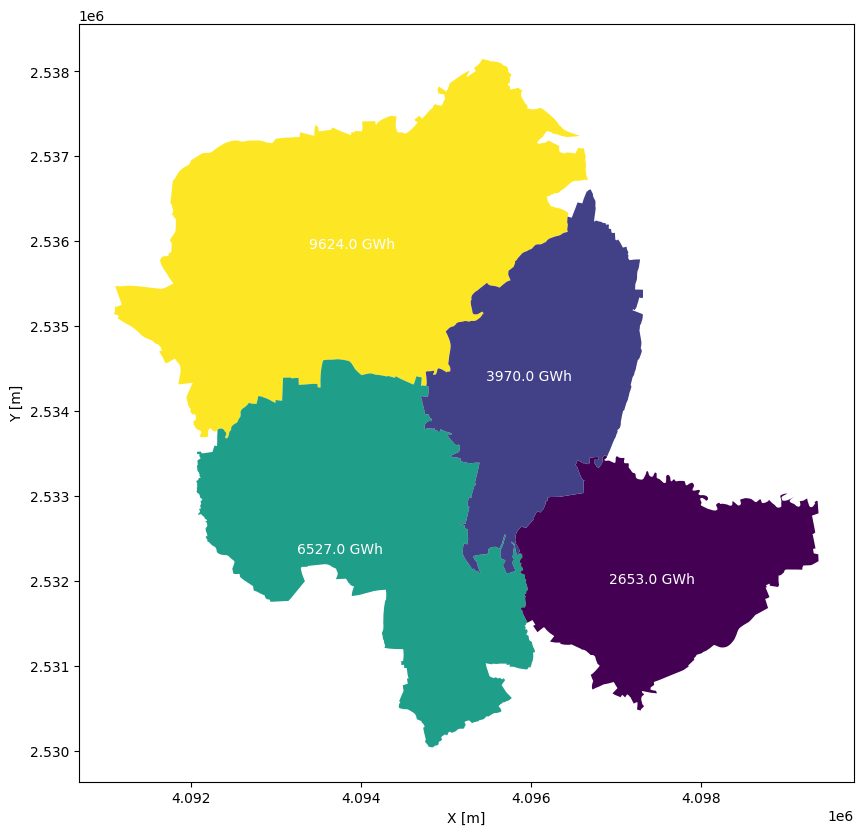

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

gdf_hd.plot(column='HD', ax=ax)

gdf_hd['coords'] = gdf_hd['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_hd['coords'] = [coords[0] for coords in gdf_hd['coords']]
for idx, row in gdf_hd.iterrows():
    
    ax.annotate(text=str(np.round(row['HD']/1000,
                                   0)) + ' GWh', 
                 xy=row['coords'],
                 horizontalalignment='center', 
                 color = 'white')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Performing second spatial join to get total HD value of community for each polygon

In [15]:
leftjoin_gdf2 = gpd.sjoin(left_df=hd_hotmaps_overlay,
                             right_df=gdf_hd,
                             how='left')
leftjoin_gdf2.head()

,HD_factori,HeatDemand,area,index_right0_left,index_right1_left,qbedarfges_left,geometry,area_new,HD_left,index_right,HD_right,index_right0_right,index_right1_right,qbedarfges_right,coords
0,0.000659,0.445521,6755.763078,0,0,52210990.0,"POLYGON ((4091480.599 2534852.714, 4091452.682...",6755.763078,0.445521,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)"
1,0.000388,0.387671,10000.000000,0,0,52210990.0,"POLYGON ((4091484.540 2535046.940, 4091484.540...",10000.000000,0.387671,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)"
2,0.000808,0.806375,9979.095516,0,0,52210990.0,"POLYGON ((4091484.540 2534851.090, 4091484.540...",9979.095516,0.806375,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)"
3,0.000761,0.761312,10000.000000,0,0,52210990.0,"POLYGON ((4091584.540 2535046.940, 4091584.540...",10000.000000,0.761312,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)"
4,0.455978,307.432628,6742.271536,0,0,52210990.0,"POLYGON ((4091782.790 2534604.113, 4091734.811...",6742.271536,307.432628,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)"


## Calculating Fraction of Heat Demand

In [16]:
leftjoin_gdf2['HD_fraction'] = leftjoin_gdf2['HD_left']/leftjoin_gdf2['HD_right']
leftjoin_gdf2.head()

,HD_factori,HeatDemand,area,index_right0_left,index_right1_left,qbedarfges_left,geometry,area_new,HD_left,index_right,HD_right,index_right0_right,index_right1_right,qbedarfges_right,coords,HD_fraction
0,0.000659,0.445521,6755.763078,0,0,52210990.0,"POLYGON ((4091480.599 2534852.714, 4091452.682...",6755.763078,0.445521,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",4.629181e-08
1,0.000388,0.387671,10000.000000,0,0,52210990.0,"POLYGON ((4091484.540 2535046.940, 4091484.540...",10000.000000,0.387671,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",4.028097e-08
2,0.000808,0.806375,9979.095516,0,0,52210990.0,"POLYGON ((4091484.540 2534851.090, 4091484.540...",9979.095516,0.806375,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",8.378639e-08
3,0.000761,0.761312,10000.000000,0,0,52210990.0,"POLYGON ((4091584.540 2535046.940, 4091584.540...",10000.000000,0.761312,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",7.910407e-08
4,0.455978,307.432628,6742.271536,0,0,52210990.0,"POLYGON ((4091782.790 2534604.113, 4091734.811...",6742.271536,307.432628,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",3.194378e-05


In [17]:
leftjoin_gdf2['HD_final'] = leftjoin_gdf2['qbedarfges_right']*leftjoin_gdf2['HD_fraction']
leftjoin_gdf2.head()

,HD_factori,HeatDemand,area,index_right0_left,index_right1_left,qbedarfges_left,geometry,area_new,HD_left,index_right,HD_right,index_right0_right,index_right1_right,qbedarfges_right,coords,HD_fraction,HD_final
0,0.000659,0.445521,6755.763078,0,0,52210990.0,"POLYGON ((4091480.599 2534852.714, 4091452.682...",6755.763078,0.445521,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",4.629181e-08,2.416941
1,0.000388,0.387671,10000.000000,0,0,52210990.0,"POLYGON ((4091484.540 2535046.940, 4091484.540...",10000.000000,0.387671,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",4.028097e-08,2.103110
2,0.000808,0.806375,9979.095516,0,0,52210990.0,"POLYGON ((4091484.540 2534851.090, 4091484.540...",9979.095516,0.806375,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",8.378639e-08,4.374570
3,0.000761,0.761312,10000.000000,0,0,52210990.0,"POLYGON ((4091584.540 2535046.940, 4091584.540...",10000.000000,0.761312,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",7.910407e-08,4.130102
4,0.455978,307.432628,6742.271536,0,0,52210990.0,"POLYGON ((4091782.790 2534604.113, 4091734.811...",6742.271536,307.432628,0,9.624178e+06,0,0,52210990.0,"(4093887.43553358, 2535912.05946609)",3.194378e-05,1667.816354


In [18]:
data = leftjoin_gdf2[['HD_final', 'geometry']]
data.head()

,HD_final,geometry
0,2.416941,"POLYGON ((4091480.599 2534852.714, 4091452.682..."
1,2.103110,"POLYGON ((4091484.540 2535046.940, 4091484.540..."
2,4.374570,"POLYGON ((4091484.540 2534851.090, 4091484.540..."
3,4.130102,"POLYGON ((4091584.540 2535046.940, 4091584.540..."
4,1667.816354,"POLYGON ((4091782.790 2534604.113, 4091734.811..."


Text(70.22222222222221, 0.5, 'Y [m]')

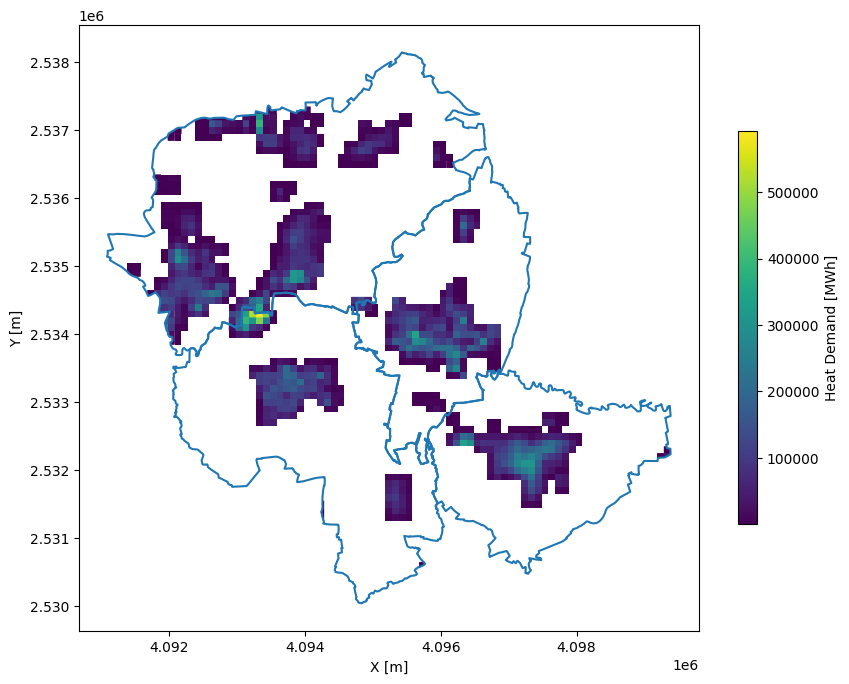

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

boundaries.boundary.plot(ax=ax)
data.plot(ax=ax, column='HD_final', legend=True, legend_kwds={'shrink':0.51, 'label': 'Heat Demand [MWh]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Inspect CRS

We are inspecting the CRS and see that is does not match with the desired CRS `EPSG:3034`.

In [20]:
data.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

## Creating GeoDataFrame Outline from vectorized Raster

For further processing, we are creating an outline `GeoDataFrame` from the `total_bounds` of the vectorized raster.

In [21]:
gdf = processing.create_outline(data)
gdf

,geometry
0,"POLYGON ((4099382.790 2530571.850, 4099382.790..."


## Loading Interreg Mask

We are loading the previously created 10km mask. 

In [22]:
mask_10km = gpd.read_file('../../../test/data/Interreg_NWE_mask_10km_3034.shp')
mask_10km

,FID,geometry
0,0,"POLYGON ((2651470.877 2955999.353, 2651470.877..."
1,1,"POLYGON ((2651470.877 2965999.353, 2651470.877..."
2,2,"POLYGON ((2651470.877 2975999.353, 2651470.877..."
3,3,"POLYGON ((2651470.877 2985999.353, 2651470.877..."
4,4,"POLYGON ((2651470.877 2995999.353, 2651470.877..."
...,...,...
9225,9225,"POLYGON ((4141470.877 2605999.353, 4141470.877..."
9226,9226,"POLYGON ((4141470.877 2615999.353, 4141470.877..."
9227,9227,"POLYGON ((4151470.877 2585999.353, 4151470.877..."
9228,9228,"POLYGON ((4151470.877 2595999.353, 4151470.877..."


In [23]:
mask_10km.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

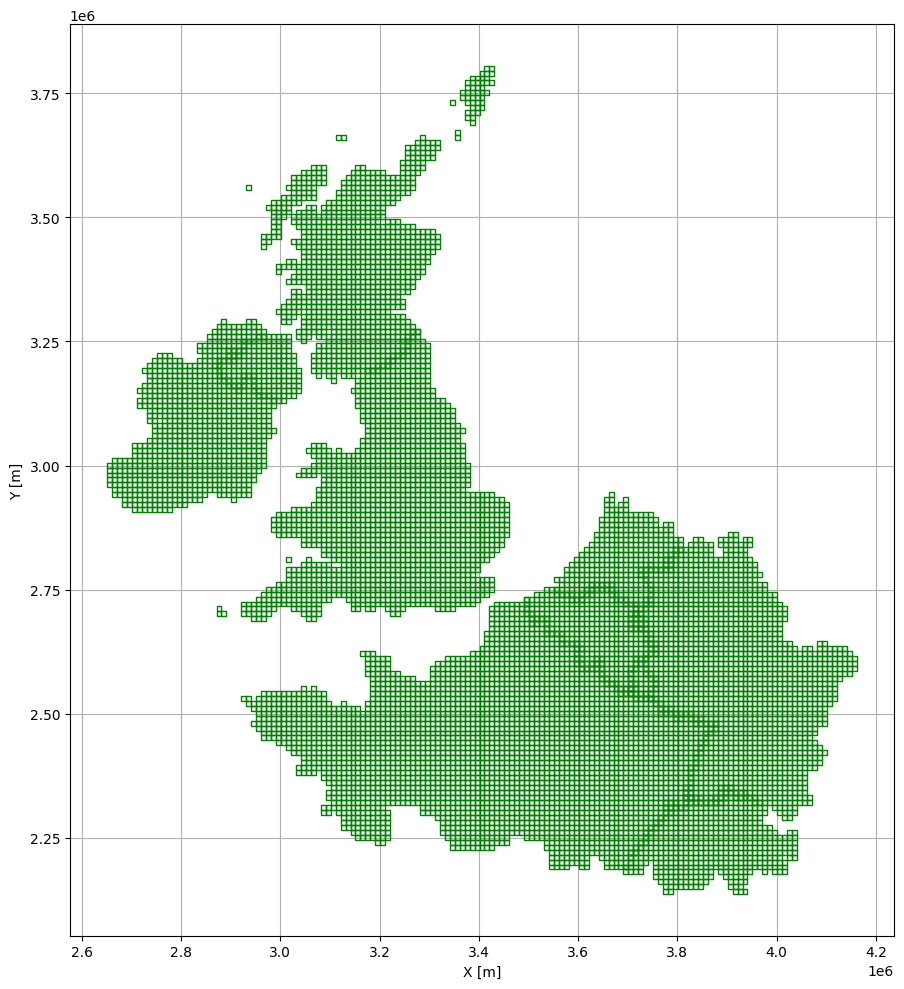

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km.boundary.plot(ax=ax, linewidth=1, color='green')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Crop Mask to Data Limits

The 10km cells that intersect with the data outline are selected. 

In [25]:
mask_10km_cropped = mask_10km.sjoin(gdf).reset_index()[['geometry']]
mask_10km_cropped

,geometry
0,"POLYGON ((4081470.877 2525999.353, 4081470.877..."
1,"POLYGON ((4081470.877 2535999.353, 4081470.877..."
2,"POLYGON ((4091470.877 2525999.353, 4091470.877..."
3,"POLYGON ((4091470.877 2535999.353, 4091470.877..."


## Plotting the Cropped Mask

The cropped mask and the data outline are plotted using `matplotlib`. 

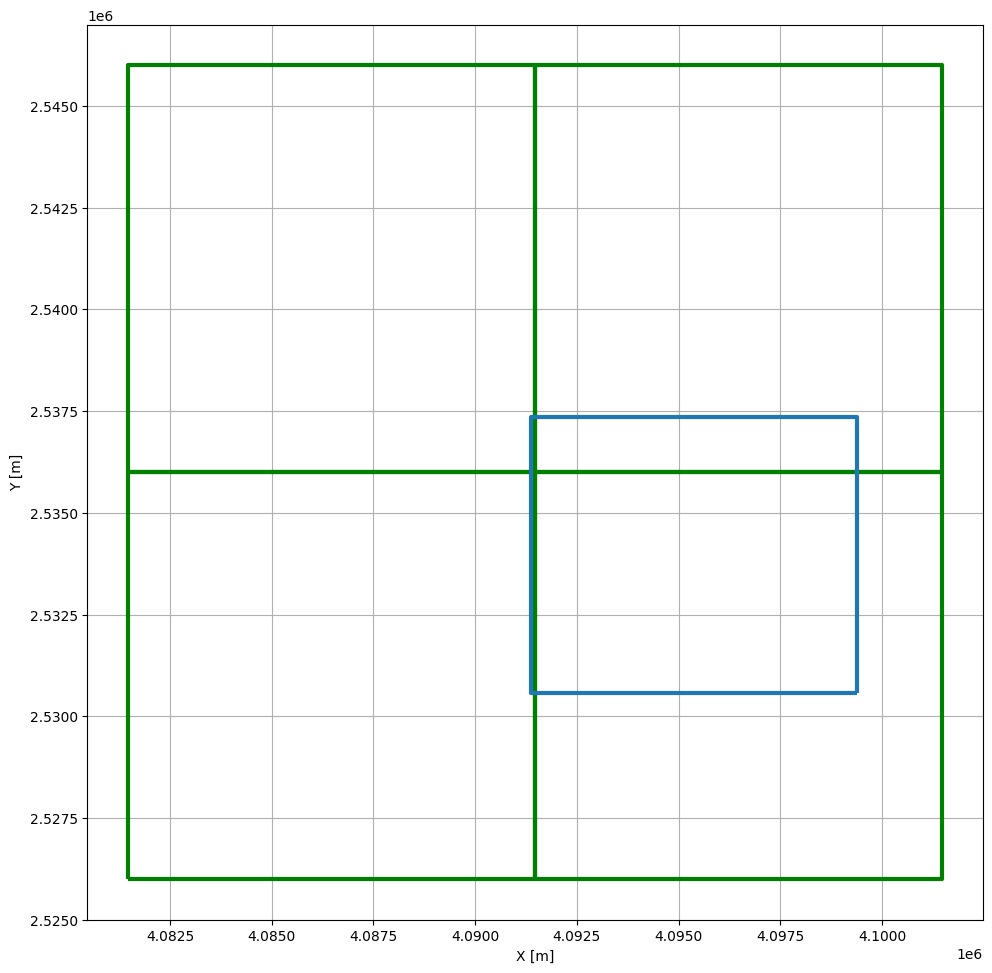

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=3, color='green')
gdf.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=3)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Creating mask from cropped mask

Here, the final mask with a width and height of 100m is created. 

In [27]:
mask_100m_cropped = processing.create_polygon_mask(gdf=mask_10km_cropped, 
                                                   step_size=100,
                                                   crop_gdf=True)
mask_100m_cropped

,geometry
0,"POLYGON ((4081470.877 2525999.353, 4081570.877..."
1,"POLYGON ((4081470.877 2526099.353, 4081570.877..."
2,"POLYGON ((4081470.877 2526199.353, 4081570.877..."
3,"POLYGON ((4081470.877 2526299.353, 4081570.877..."
4,"POLYGON ((4081470.877 2526399.353, 4081570.877..."
...,...
40799,"POLYGON ((4101370.877 2545499.353, 4101470.877..."
40800,"POLYGON ((4101370.877 2545599.353, 4101470.877..."
40801,"POLYGON ((4101370.877 2545699.353, 4101470.877..."
40802,"POLYGON ((4101370.877 2545799.353, 4101470.877..."


## Cropping Mask to outline

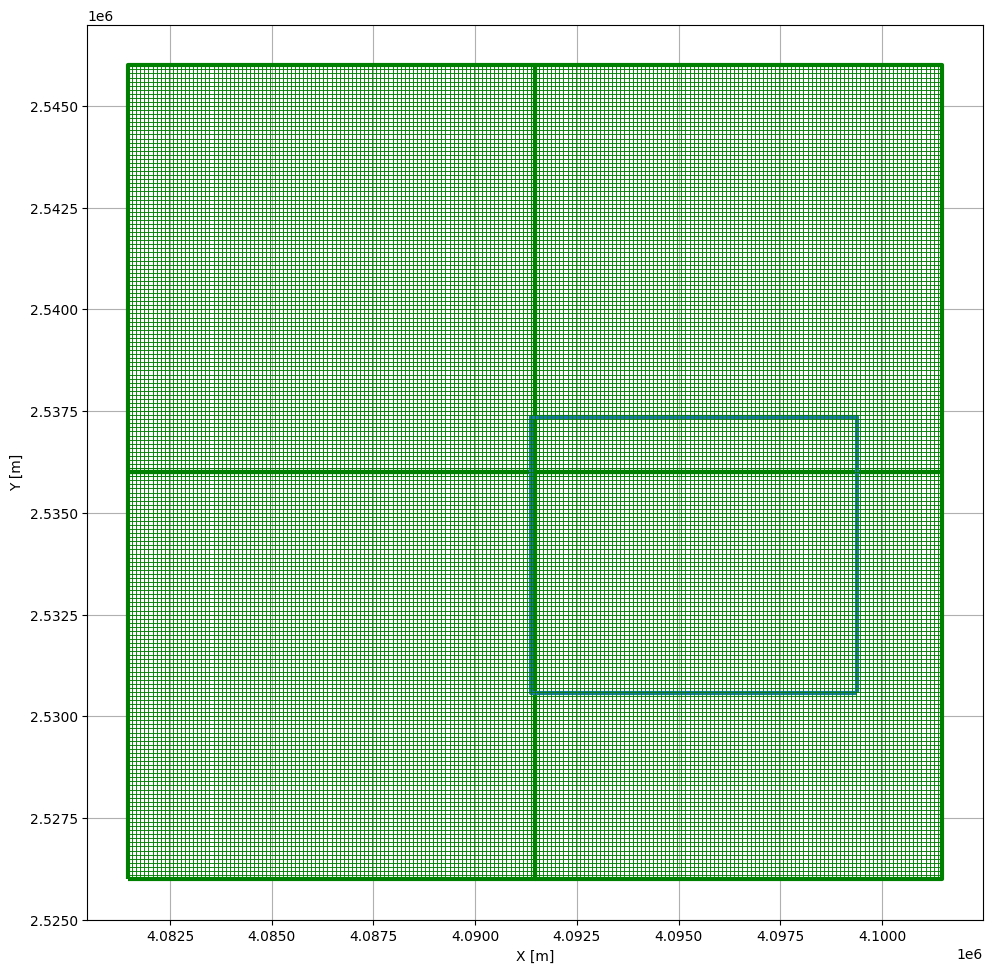

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=3, color='green')
gdf.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=3)
mask_100m_cropped.boundary.plot(ax=ax, linewidth=0.5, color='green')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

#plt.savefig('../images/Data_Type_1_Outline.png', dpi=300)

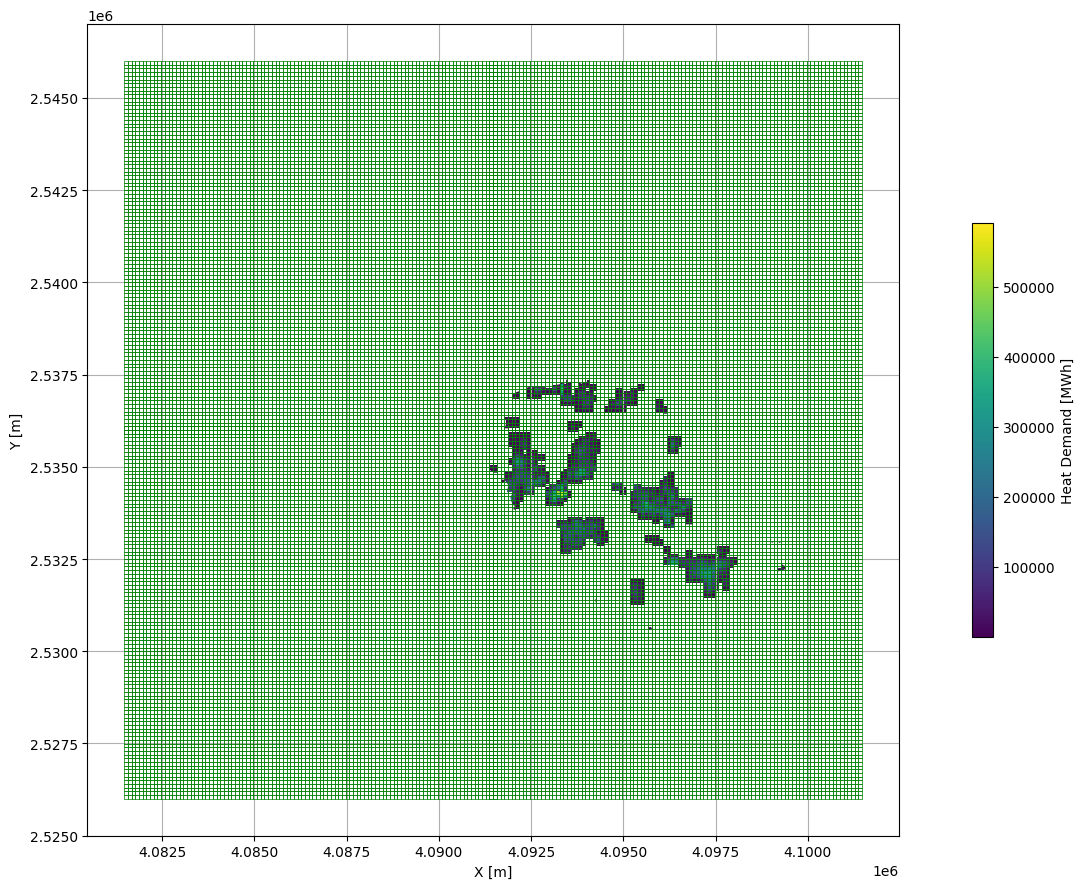

In [29]:
fig, ax = plt.subplots(figsize=(15,9))

mask_100m_cropped.boundary.plot(ax=ax, linewidth=0.5, color='green')
data.plot(ax=ax, column='HD_final', legend=True, legend_kwds={'shrink':0.51, 'label': 'Heat Demand [MWh]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Calculate Heat Demand

With the vectorized raster and the 100m mask, we can now directly calculate the heat demand using `calculate_hd`. 

In [30]:
hd_gdf = data
mask_gdf = mask_100m_cropped

In [31]:
gdf_hd = processing.calculate_hd(hd_gdf, 
                                 mask_gdf, 
                                 'HD_final')
gdf_hd 

,HD,geometry
0,2.315712,"POLYGON ((4091370.877 2534799.353, 4091470.877..."
1,9.339765,"POLYGON ((4091370.877 2534899.353, 4091470.877..."
2,3.456231,"POLYGON ((4091370.877 2534999.353, 4091470.877..."
3,8.786896,"POLYGON ((4091470.877 2534799.353, 4091570.877..."
4,16.212892,"POLYGON ((4091470.877 2534899.353, 4091570.877..."
...,...,...
1280,239.620343,"POLYGON ((4096070.877 2536699.353, 4096170.877..."
1281,27.062158,"POLYGON ((4096070.877 2536799.353, 4096170.877..."
1282,1.667002,"POLYGON ((4096170.877 2536399.353, 4096270.877..."
1283,20.250093,"POLYGON ((4096170.877 2536499.353, 4096270.877..."


Text(70.22222222222221, 0.5, 'Y [m]')

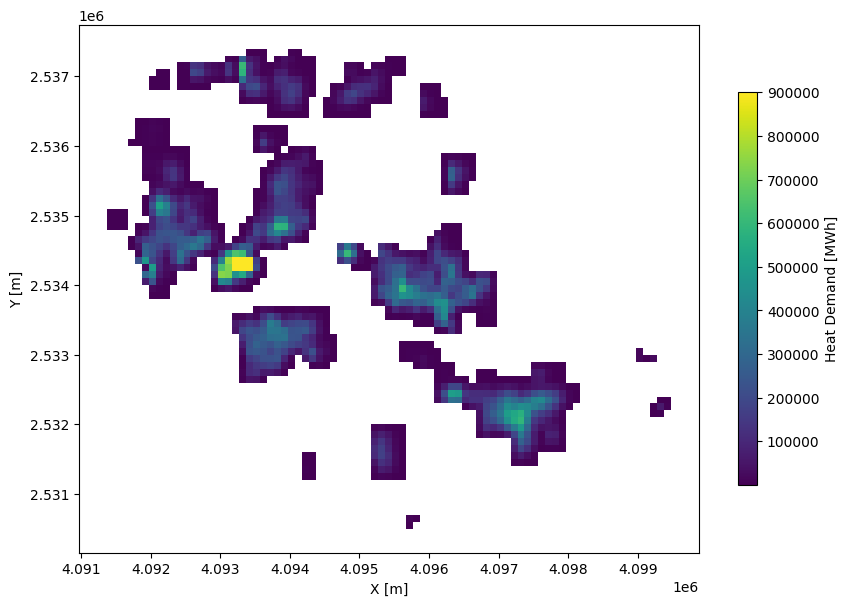

In [32]:
fig, ax = plt.subplots(figsize=(10,10))

gdf_hd.plot(ax=ax,column='HD', vmax=900000, legend=True, legend_kwds={'shrink':0.51, 'label': 'Heat Demand [MWh]'})

plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Rasterizing Vector Data

The vector data will be rasterized and saved to file.

In [33]:
processing.rasterize_gdf_hd(gdf_hd, 
                     path_out='../../../test/data/Data_Type_III_Points_Coordinates.tif',
                     crs = 'EPSG:3034', 
                     xsize = 100,
                     ysize = 100, 
                     flip_raster=True)

## Opening and plotting raster
The final raster can now be opened and plotted. 

In [34]:
raster = rasterio.open('../../../test/data/Data_Type_III_Points_Coordinates.tif')

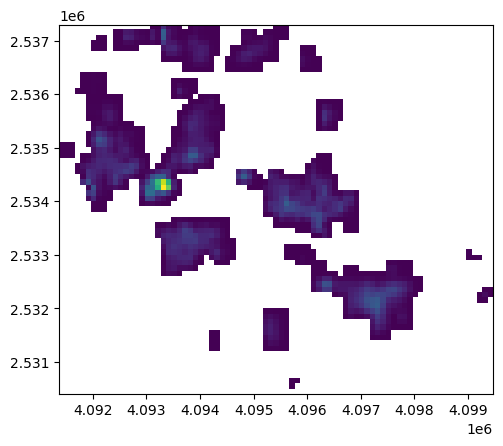

<Axes: >

In [35]:
show(raster)